In [1]:
using WindTunnelFlow
using Plots

In [2]:
function suction_velocity!(vel,pts,t,phys_params)
    V_out = phys_params["V_SD"]
    vel .= -V_out
#     vel .= 0.0
end

function inflow_velocity!(vel,pts,t,phys_params)
    V_in = phys_params["V_in"]
    vel .= V_in
end

inflow_velocity! (generic function with 1 method)

In [3]:
# Airfoil characteristics

c = 0.245 # m
α = 0 # degrees

0

In [4]:
# Wind tunnel characteristics

H_TS = 0.61 # m
W_TS = 0.61 # m
L_TS = 2.1 # m

V_in = 1.0 * c # m/s
Q_SD_over_Q_in = 0.1
x_SD_lo_over_L_TS = 0.4
x_SD_hi_over_L_TS = 0.6

0.6

In [5]:
# Rescale every length by the chord length
c_star = c / c
H_TS_star = H_TS / c
W_TS_star = W_TS / c
L_TS_star = L_TS / c
V_in_star = V_in / c # m/s

1.0

In [6]:
A_TS_star = H_TS_star * W_TS_star
Q_in_star = V_in_star * A_TS_star
Q_SD_star = Q_SD_over_Q_in * Q_in_star

x_SD_lo_star = x_SD_lo_over_L_TS * L_TS_star
x_SD_hi_star = x_SD_hi_over_L_TS * L_TS_star
L_SD_star = x_SD_hi_star - x_SD_lo_star
A_SD_star = L_SD_star * W_TS_star
V_SD_star = Q_SD_star / A_SD_star

0.14523809523809533

In [7]:
params = Dict()
params["Re"] = 100
params["grid Re"] = 6.0
params["wind tunnel length"] = L_TS_star
params["wind tunnel height"] = H_TS_star
params["wind tunnel center"] = (L_TS_star / 2, H_TS_star / 2)
params["freestream speed"] = V_in_star
params["freestream angle"] = 0.0
params["V_in"] = V_in_star
params["V_SD"] = V_SD_star
t_final = 5.0
xlim = (-0.05 * L_TS_star, 1.05 * L_TS_star)
ylim = (-0.05 * H_TS_star, 1.05 * H_TS_star)
g = setup_grid(xlim, ylim, params)

PhysicalGrid{2}((160, 49), (9, 4), 0.06, ((-0.48, 9.0), (-0.18, 2.6399999999999997)))

In [8]:
# Airfoil in the test section

Δs = surface_point_spacing(g,params)
airfoil = NACA4(0.0, 0.0, 0.09, 300, len=c_star)
airfoil = SplinedBody(airfoil.x, airfoil.y, Δs)
T = RigidTransform((L_TS_star / 2, H_TS_star / 2), -α*π/180)
T(airfoil) # transform the body to the current configuration

Basic pointwise-specified body with 24 points
   Current position: (4.285714285714286,1.2448979591836735)
   Current angle (rad): 0.0


In [9]:
# Create the inflow

N = ceil(Int, H_TS_star / surface_point_spacing(g,params))
inflow_boundary = BasicBody(
    zeros(N),
    collect(range(0, H_TS_star, N)),
    closuretype=RigidBodyTools.OpenBody)
inflow = UniformFlowThrough(inflow_boundary,inflow_velocity!,3)

params["inlets"] = [inflow]

1-element Vector{UniformFlowThrough}:
 UniformFlowThrough(Basic pointwise-specified body with 29 points
   Current position: (0.0,0.0)
   Current angle (rad): 0.0
, inflow_velocity!, 3, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  1.6741731175228711, 1.7600281491907108, 1.8458831808585503, 1.93173821252639, 2.0175932441942295, 2.103448275862069, 2.1893033075299084, 2.275158339197748, 2.361013370865588, 2.4468684025334273], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

In [10]:
# Create the suction at the top of the wind tunnel

N = ceil(Int, L_SD_star / surface_point_spacing(g,params))
suction_boundary = BasicBody(
    collect(range(x_SD_lo_star, x_SD_hi_star, N)),
    H_TS_star * ones(N);
    closuretype=RigidBodyTools.OpenBody)
suction = UniformFlowThrough(suction_boundary,suction_velocity!,1)

params["outlets"] = [suction]

1-element Vector{UniformFlowThrough}:
 UniformFlowThrough(Basic pointwise-specified body with 20 points
   Current position: (0.0,0.0)
   Current angle (rad): 0.0
, suction_velocity!, 1, [3.4714285714285715, 3.5571428571428574, 3.6428571428571432, 3.7285714285714286, 3.814285714285714, 3.9000000000000004, 3.9857142857142858, 4.071428571428571, 4.157142857142857, 4.242857142857143  …  2.489795918367347, 2.489795918367347, 2.489795918367347, 2.489795918367347, 2.489795918367347, 2.489795918367347, 2.489795918367347, 2.489795918367347, 2.489795918367347, 2.489795918367347], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

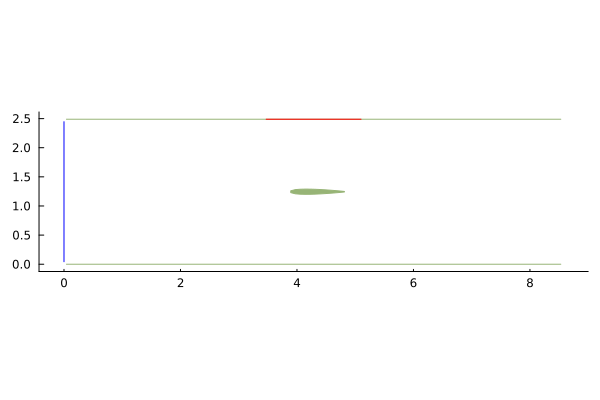

In [11]:
wt_walls = create_windtunnel_boundaries(g,params,withinlet=false)
plot(airfoil)
plot!(wt_walls,xlim=xlim,ylim=ylim)
plot!(suction.boundary,lc=:red)
plot!(inflow.boundary,lc=:blue)

In [12]:
prob = WindTunnelProblem(g,airfoil,phys_params=params;timestep_func=ViscousFlow.DEFAULT_TIMESTEP_FUNC,
                                   bc=ViscousFlow.get_bc_func(nothing))
sys = construct_system(prob);

In [13]:
u0 = init_sol(sys)
tspan = (0.0,t_final)
integrator = init(u0,tspan,sys);

In [ ]:
step!(integrator,t_final)
sol = integrator.sol;
fx, fy = force(sol,sys,1);

In [ ]:
anim_sample_freq = 5 # samples per simulated time unit
anim_fps = 24 # frames per second of real time
Δt = prob.timestep_func(sys) # simulated time per time step
anim_sample_step = ceil(Int,1/(Δt*anim_sample_freq)) # time steps per sample

In [ ]:
pts = points(suction.boundary)
vel = ScalarData(pts)
Q_suction = []
for i in 1:length(sol.t)
    suction_velocity!(vel,suction.boundary,sol.t[i],params)
    Q_suction_i = -integrate(vel,ScalarData(dlength(suction.boundary))) * W_TS_star
    push!(Q_suction,Q_suction_i)
end

In [ ]:
ψ = zeros_gridcurl(sys)
ViscousFlow.streamfunction!(ψ,sol.u[end].x[1],sys,sol.t[end])
y_probe = 0:0.1*H_TS_star:H_TS_star
ψ_fcn = interpolatable_field(ψ,g)
ψ_probe = ψ_fcn.(0.0,y_probe)

anim = @animate for i in 1:anim_sample_step:length(sol.t)
#     l = @layout [a{0.6w} [Plots.grid(2,1)]]    
    ViscousFlow.streamfunction!(ψ,sol.u[i].x[1],sys,sol.t[i])
    p1=plot(ψ,sys,c=:gray,levels=ψ_probe,title="t = $(round(integrator.sol.t[i]; digits=1))",xlabel="\$x/c\$",ylabel="\$y/c\$",clim=(-10,10))
    plot!(sol.u[i].x[1],sys,clim=(-15,15),color=cgrad(:RdBu, rev = true),levels=range(-15,15,length=30))
    plot!(wt_walls,xlim=xlim,ylim=ylim,lc=:black,lw=2)
    plot!(suction.boundary,lc=:red,lw=2)
    plot!(airfoil,fc=:white,lc=:black)
    p2=plot(sol.t[1:i],Q_suction[1:i]/Q_in_star,xlim=(0.0,sol.t[end]),ylim=(0,1),ylabel="\$Q_{suction}/Q_{in}\$",legend=false)
    p3=plot(sol.t[1:i],fy[1:i],xlim=(0.0,integrator.sol.t[end]),ylim=(-3,3),xlabel="\$tU/c\$",ylabel="\$C_L\$",legend=false)
#     plot(p1,p2,p3,layout = l,size=(1000,300),margin=4mm)
    plot(p1,p2,p3, layout=Plots.grid(3, 1, heights=[0.4 ,0.15, 0.45]),size=(600,670))
end
gif(anim)